`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   





# Работа с временным рядом

### Работу выполнила Бобина Татьяна Сергеевна
###### Данные: цены на момент закрытия на акции компании 2223.SR

In [ ]:
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean


# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Загрузка данных

In [ ]:
df = yf.Ticker('2223.SR').history(interval = "1h", start = '2012-01-01')
df.shape

(412, 7)

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-12-28 10:00:00+03:00,94.000000,97.300003,94.000000,97.300003,0,0.0,0.0
2022-12-28 11:00:00+03:00,97.300003,97.300003,97.300003,97.300003,2407289,0.0,0.0
2022-12-28 12:00:00+03:00,94.099998,94.099998,94.099998,94.099998,655083,0.0,0.0
2022-12-28 13:00:00+03:00,94.099998,95.099998,94.099998,95.099998,1814472,0.0,0.0
2022-12-28 14:00:00+03:00,95.099998,95.699997,95.000000,95.400002,433831,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-01 10:00:00+03:00,111.199997,113.800003,110.800003,113.400002,0,5.0,0.0
2023-05-01 11:00:00+03:00,113.400002,113.599998,112.800003,113.400002,165383,0.0,0.0
2023-05-01 12:00:00+03:00,113.199997,113.400002,113.000000,113.199997,103894,0.0,0.0


### Оставим данные только о дате и цене на момент закрытия

> Блок с отступами



In [ ]:
df = df[['Close']]
df

,Close
Datetime,
2022-12-28 10:00:00+03:00,97.300003
2022-12-28 11:00:00+03:00,97.300003
2022-12-28 12:00:00+03:00,94.099998
2022-12-28 13:00:00+03:00,95.099998
2022-12-28 14:00:00+03:00,95.400002
...,...
2023-05-01 10:00:00+03:00,113.400002
2023-05-01 11:00:00+03:00,113.400002
2023-05-01 12:00:00+03:00,113.199997


### Строим график временного ряда

<Axes: title={'center': 'Цена на момент закрытия на акции компании'}, xlabel='Datetime'>

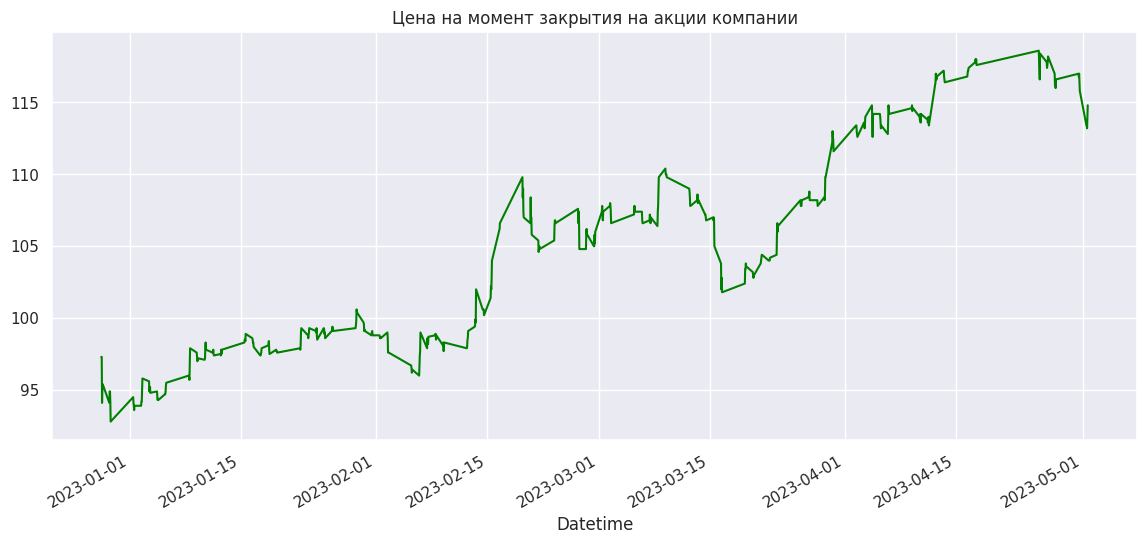

In [ ]:
df.Close.plot( figsize=(14,6),title= 'Цена на момент закрытия на акции компании', fontsize=11, color="green")

По графику нельзя точно сказать стоило или нет вкладыватся в акции компании. Видно,что ряд не стационарен. В нём можно выразить трендовую зависимость.
График показывает, что цены на акции в основном исправно с периодичными колебаниями росли в течении 4х месяцев. Можно заметить, что существует большое количество короткосрочных колебаний цен, которые не подчиняются общему тренду и вызваны внешними факторами.


### Тест Дикки-Фуллера на стационарность
Проверим на уровне значимости 0.05

In [ ]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [ ]:
sample_data = df.Close

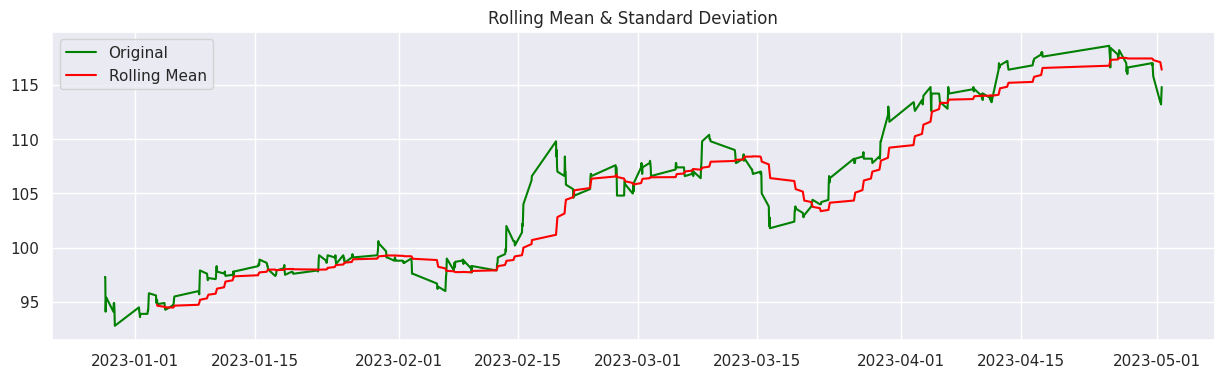

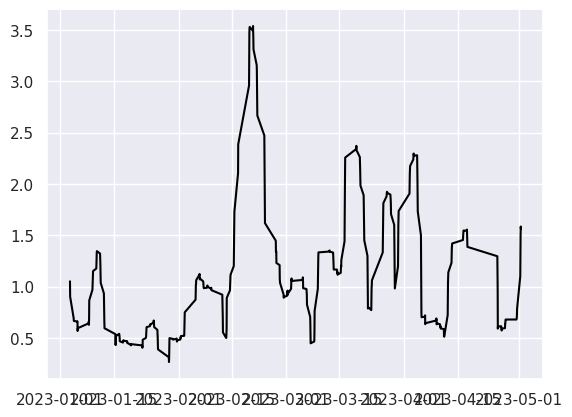

Results of Dickey-Fuller Test:
p-value = 0.8503. The series is likely non-stationary.
Test Statistic                  -0.686223
p-value                          0.850286
#Lags Used                       0.000000
Number of Observations Used    411.000000
Critical Value (1%)             -3.446361
Critical Value (5%)             -2.868598
Critical Value (10%)            -2.570530
dtype: float64


In [ ]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается большим значением p-value, превышающим уровень значимости 0.05, а также недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса

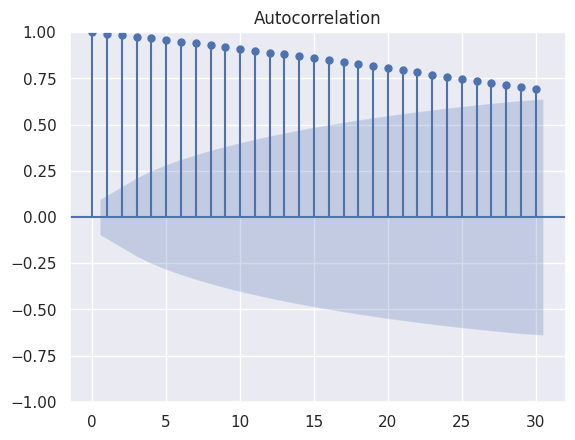

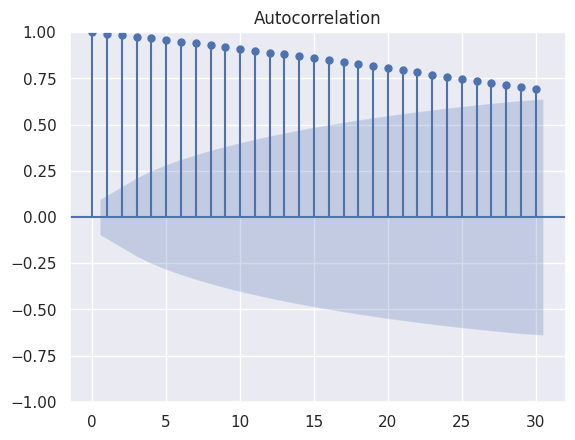

In [ ]:
plot_acf(df.Close, lags=30)

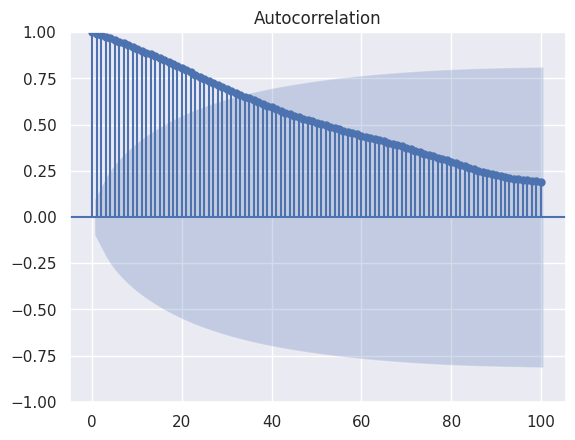

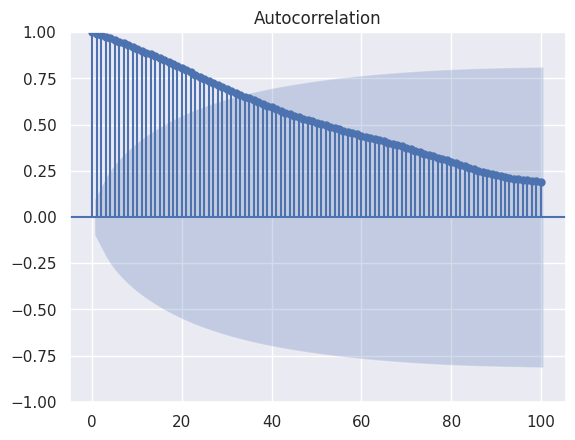

In [ ]:
plot_acf(df.Close, lags=100)

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели. Предлагается для начала избавится от трендовой зависимости

### Удалениe линейной трендовой составляющей из временного ряда

In [ ]:
df["index"] = range(1, len(df)+1, 1)

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.array(df["index"]).reshape((-1, 1))
Y = np.array(df["Close"])

model = LinearRegression().fit(X,Y)
print('Y =', model.coef_[0], '* X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))

Y = 0.055803296279246184 * X + 93.1040467805709
coefficient of determination: 0.8810120097417239


In [ ]:
df["Close_t"] = df["Close"] - (df["index"] * model.coef_[0] + model.intercept_)
df

,Close,index,Close_t
Datetime,,,
2022-12-28 10:00:00+03:00,97.300003,1,4.140153
2022-12-28 11:00:00+03:00,97.300003,2,4.084350
2022-12-28 12:00:00+03:00,94.099998,3,0.828542
2022-12-28 13:00:00+03:00,95.099998,4,1.772739
2022-12-28 14:00:00+03:00,95.400002,5,2.016938
...,...,...,...
2023-05-01 10:00:00+03:00,113.400002,408,-2.471790
2023-05-01 11:00:00+03:00,113.400002,409,-2.527593
2023-05-01 12:00:00+03:00,113.199997,410,-2.783401


<Axes: title={'center': 'Без тренда'}, xlabel='Datetime'>

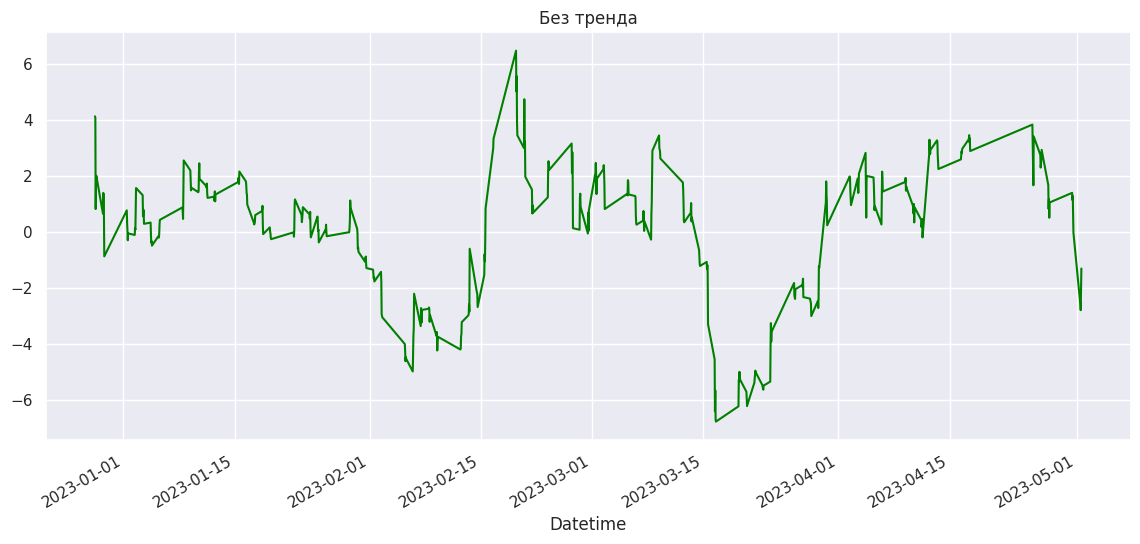

In [ ]:
df.Close_t.plot( figsize=(14,6),title= 'Без тренда', fontsize=11, color="green")

## Тест Дикки-Фуллера без тренда

In [ ]:
dftest_t = adfuller(df.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])

p-value = 0.0338. The series is likely stationary.


## Разделим данные

In [ ]:
from sklearn. model_selection import train_test_split

train, test = df[0:325], df[325:]
print(train.shape, test.shape)
test

(325, 3) (87, 3)


,Close,index,Close_t
Datetime,,,
2023-03-30 13:00:00+03:00,112.400002,326,1.104080
2023-03-30 14:00:00+03:00,111.599998,327,0.248274
2023-04-02 10:00:00+03:00,113.400002,328,1.992474
2023-04-02 11:00:00+03:00,113.400002,329,1.936670
2023-04-02 12:00:00+03:00,113.000000,330,1.480865
...,...,...,...
2023-05-01 10:00:00+03:00,113.400002,408,-2.471790
2023-05-01 11:00:00+03:00,113.400002,409,-2.527593
2023-05-01 12:00:00+03:00,113.199997,410,-2.783401


In [ ]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MSE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order = params)
    result_test = model_test.fit()
    if result_test.mse < best_MSE:
        best_params = params
        best_MSE = result_test.mse
print(best_params, best_MSE)

  0%|          | 0/240 [00:00<?, ?it/s]

(5, 0, 9) 0.41109117012709284


Таким образом на преобразованных данных можно построить модель ARIMA(5,0,9)

In [ ]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MSE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close, order = params)
    result_test = model_test.fit()
    if result_test.mse < best_MSE:
        best_params = params
        best_MSE = result_test.mse
print(best_params, best_MSE)

  0%|          | 0/240 [00:00<?, ?it/s]

(5, 0, 6) 0.4499953081537257


Таким образом на исходных данных можно построить модель ARIMA(5,0,6). Даёт лучшие результаты

## Проверим модель на тестовой выборке

In [ ]:
test.Close


Datetime
2023-03-30 13:00:00+03:00    112.400002
2023-03-30 14:00:00+03:00    111.599998
2023-04-02 10:00:00+03:00    113.400002
2023-04-02 11:00:00+03:00    113.400002
2023-04-02 12:00:00+03:00    113.000000
                                ...    
2023-05-01 10:00:00+03:00    113.400002
2023-05-01 11:00:00+03:00    113.400002
2023-05-01 12:00:00+03:00    113.199997
2023-05-01 13:00:00+03:00    114.000000
2023-05-01 14:00:00+03:00    114.800003
Name: Close, Length: 87, dtype: float64

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
model_test = sm.tsa.arima.ARIMA(test.Close, order = (2,1,4))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

mean_absolute_percentage_error(test.Close, preds)

1.5777664865938856

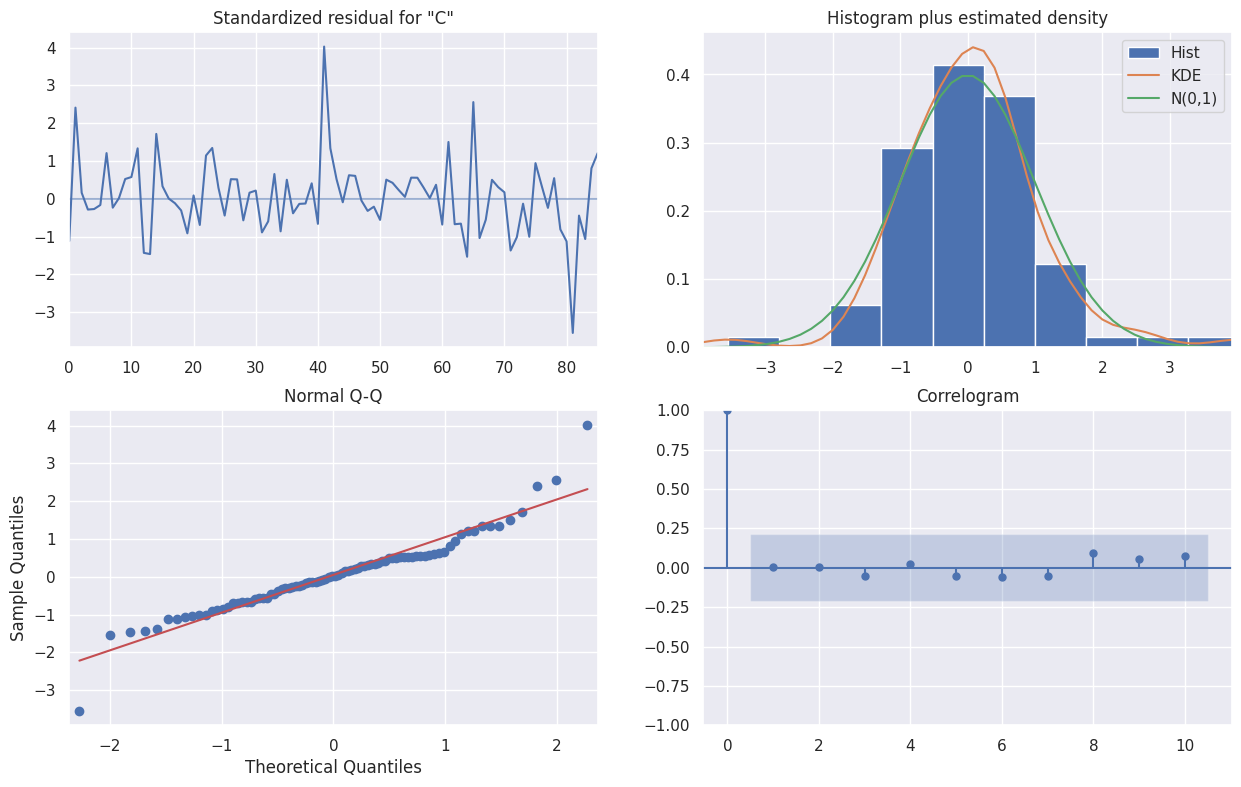

In [ ]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()

## Построим прогноз

In [ ]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int().reset_index(drop=True)
print(pred_ci)
type(pred_ci)

   lower Close  upper Close
0   113.295488   115.993588
1   112.832011   116.432075
2   112.380667   116.551256
3   112.140499   116.729580
4   112.145010   117.065961
5   111.846626   117.175936
6   111.584328   117.268411
7   111.592230   117.550177
8   111.403712   117.683343
9   111.136774   117.731111


pandas.core.frame.DataFrame

In [ ]:
y = pd.Series(test.Close, index=test.index)
y

Datetime
2023-03-30 13:00:00+03:00    112.400002
2023-03-30 14:00:00+03:00    111.599998
2023-04-02 10:00:00+03:00    113.400002
2023-04-02 11:00:00+03:00    113.400002
2023-04-02 12:00:00+03:00    113.000000
                                ...    
2023-05-01 10:00:00+03:00    113.400002
2023-05-01 11:00:00+03:00    113.400002
2023-05-01 12:00:00+03:00    113.199997
2023-05-01 13:00:00+03:00    114.000000
2023-05-01 14:00:00+03:00    114.800003
Name: Close, Length: 87, dtype: float64

In [ ]:
dti = pd.date_range("2023-05-01 14:00:00+03:00", periods=10, freq="1H")
dti

DatetimeIndex(['2023-05-01 14:00:00+03:00', '2023-05-01 15:00:00+03:00',
               '2023-05-01 16:00:00+03:00', '2023-05-01 17:00:00+03:00',
               '2023-05-01 18:00:00+03:00', '2023-05-01 19:00:00+03:00',
               '2023-05-01 20:00:00+03:00', '2023-05-01 21:00:00+03:00',
               '2023-05-01 22:00:00+03:00', '2023-05-01 23:00:00+03:00'],
              dtype='datetime64[ns, pytz.FixedOffset(180)]', freq='H')

In [ ]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

In [ ]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[114.64453797 114.63204323 114.46596143 114.43503953 114.60548568
 114.51128058 114.42636945 114.57120327 114.54352776 114.43394231]


pandas.core.series.Series

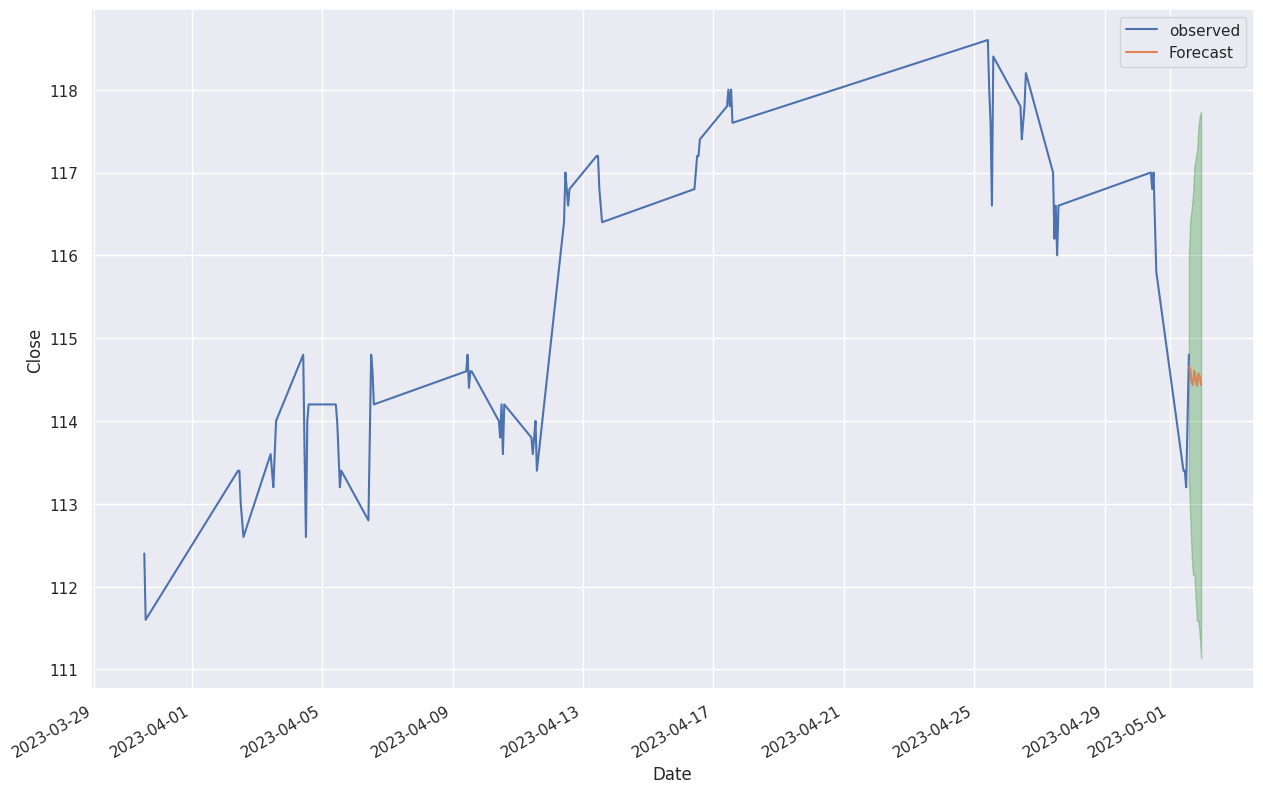

In [ ]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()


Исходя из анализа графика, можно сделать вывод, что в будущем цены на акции компании скорее всего не будут повышаться.

## Построение моделей для прогноза по разным периодам

<Axes: title={'center': 'Цена закрытия акции'}, xlabel='Datetime'>

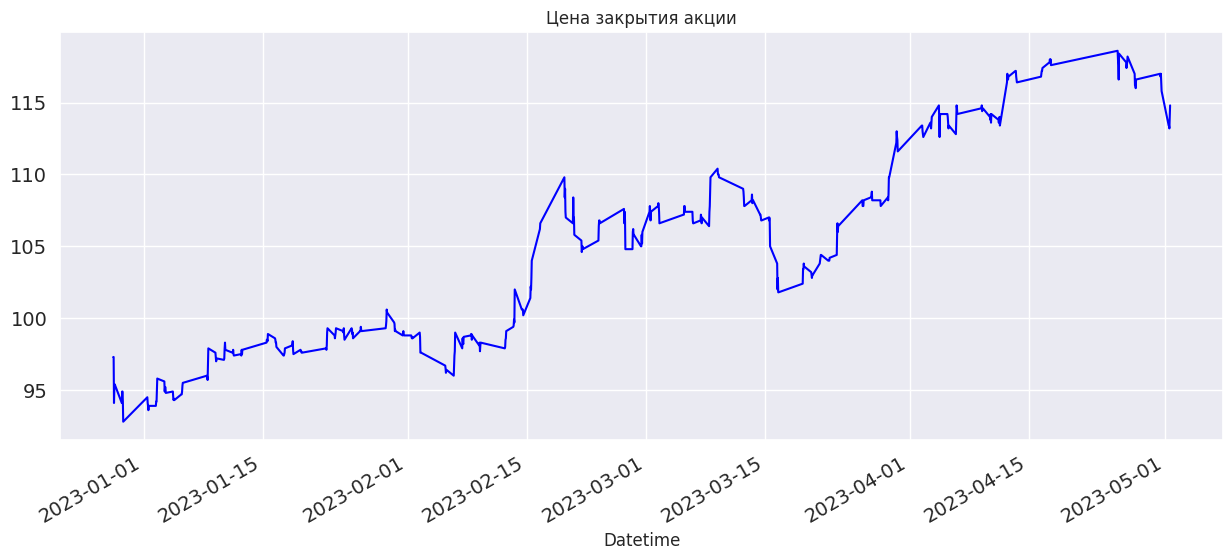

In [ ]:
df = yf.Ticker('2223.SR').history(interval = "1h", start = '2013-01-01')
df = df[['Close']]
df.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="blue")

### Требуется разделить исходные данные на 3 блока Предлагается взять такие интервалы:

1. 2023-01-01 - 2023-02-01

2. 2023-02-01 - 2023-03-15

3. 2023-03-15 - н.в.

In [ ]:
df_1 = df.index < '2023-02-01 00:00:00+03:00'
df_1 = df.loc[df_1]
df_1

,Close
Datetime,
2022-12-28 10:00:00+03:00,97.300003
2022-12-28 11:00:00+03:00,97.300003
2022-12-28 12:00:00+03:00,94.099998
2022-12-28 13:00:00+03:00,95.099998
2022-12-28 14:00:00+03:00,95.400002
...,...
2023-01-31 10:00:00+03:00,98.800003
2023-01-31 11:00:00+03:00,99.000000
2023-01-31 12:00:00+03:00,99.099998


In [ ]:
df_2 = df.query("index >= '2023-02-01 00:00:00+03:00' & index < '2023-03-15 00:00:00+03:00'")
df_2

,Close
Datetime,
2023-02-01 10:00:00+03:00,98.800003
2023-02-01 11:00:00+03:00,98.699997
2023-02-01 12:00:00+03:00,98.599998
2023-02-01 13:00:00+03:00,98.699997
2023-02-01 14:00:00+03:00,98.599998
...,...
2023-03-14 10:00:00+03:00,107.199997
2023-03-14 11:00:00+03:00,107.199997
2023-03-14 12:00:00+03:00,107.000000


In [ ]:
df_3 = df.query("index > '2023-03-15 00:00:00+03:00'")
df_3

,Close
Datetime,
2023-03-15 10:00:00+03:00,107.000000
2023-03-15 11:00:00+03:00,106.800003
2023-03-15 12:00:00+03:00,107.000000
2023-03-15 13:00:00+03:00,106.800003
2023-03-15 14:00:00+03:00,105.000000
...,...
2023-05-01 10:00:00+03:00,113.400002
2023-05-01 11:00:00+03:00,113.400002
2023-05-01 12:00:00+03:00,113.199997


### Разделим выборку на тестовую и обучающую

In [ ]:
train_1, test_1 = df_1[0:106], df_1[106:]
train_2, test_2 = df_2[0:120], df_2[120:]
train_3, test_3 = df_3[0:124], df_3[124:]

In [ ]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MSE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_1.Close, order = params)
    result_test = model_test.fit()
    if result_test.mse < best_MSE:
        best_params = params
        best_MSE = result_test.mse
        
model_test = sm.tsa.arima.ARIMA(test_1.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'на train:',best_MSE, 'на test:', result_test.mse)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 1 block: (3, 0, 8) на train: 0.2643134718031871 на test: 0.059774010776352846


In [ ]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MSE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_2.Close, order = params)
    result_test = model_test.fit()
    if result_test.mse < best_MSE:
        best_params = params
        best_MSE = result_test.mse
        
model_test = sm.tsa.arima.ARIMA(test_2.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 2 block:', best_params, 'на train:',best_MSE, 'на test:', result_test.mse)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 2 block: (4, 0, 9) на train: 0.6535265896503675 на test: 0.13068005808375707


In [ ]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MSE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_3.Close, order = params)
    result_test = model_test.fit()
    if result_test.mse < best_MSE:
        best_params = params
        best_MSE = result_test.mse
        
model_test = sm.tsa.arima.ARIMA(test_3.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 3 block:', best_params, 'на train:',best_MSE, 'на test:', result_test.mse)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 3 block: (4, 0, 9) на train: 0.5458238659109573 на test: 0.5274282194729063


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (3,0,8) и достигает MSE на тренировочной выборке в размере 0.264, а на тестовой - 0.0598. Лучшая модель на втором блоке данных имеет порядок (4,0,9) и достигает MSE на тренировочной выборке в размере 0.6535, а на тестовой - 0.131. Лучшая модель на третьем блоке данных имеет порядок (4,0,9) и достигает MSE на тренировочной выборке в размере 0.5458, а на тестовой - 0.527.

Модель с наименьшим значением MSE на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на первом блоке данных и имеет порядок (3,0,8).